# AdventureGame Evaluation
This notebook produces tables and plots to analyse AdventureGame results. All plots and tables appearing in the AdventureGame paper are created using the contained code.

In [16]:
import sys
# sys.path.append('..')

from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon

import evaluation.evalutils as utils
from evaluation.makingtables import build_dispersion_table
import clemgame.metrics as clemmetrics

Choose path for the .csv with the raw scores. This is created after running ```bencheval.py```.

In [17]:
RAW_PATH = Path('results/raw.csv')
raw_df = pd.read_csv(RAW_PATH, index_col=0)

Full results dataframe:

In [18]:
raw_df

,game,model,experiment,episode,metric,value
0,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Violated Request Count,0.0
1,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Parsed Request Count,50.0
2,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Request Count,50.0
3,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,Request Success Ratio,1.0
4,adventuregame,gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF...,0_home_deliver_three_basic_easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
36731,adventuregame,Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0,3_home_deliver_three_planning_hard,episode_5,Played,0.0
36732,adventuregame,Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0,3_home_deliver_three_planning_hard,episode_6,Played,0.0
36733,adventuregame,Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0,3_home_deliver_three_planning_hard,episode_7,Played,0.0
36734,adventuregame,Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0,3_home_deliver_three_planning_hard,episode_8,Played,0.0


Dictionaries for converting full model, experiment and score/metric names to compact names:

In [19]:
model_name_dict = {
    'gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF-q5-t0.0': "gemma-2-9b-it-q5",
    'gemma-7b-it-Groq-t0.0--gemma-7b-it-Groq-t0.0': "gemma-7b-it",
    'gemma2-9b-it-Groq-t0.0--gemma2-9b-it-Groq-t0.0': "gemma2-9b-it",
    'Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Instruct-Groq-t0.0': "Llama-3-70B-Instruct",
    'Llama-3-8B-Instruct-Groq-t0.0--Llama-3-8B-Instruct-Groq-t0.0': "Llama-3-8B-Instruct",
    'llama-3.1-70b-versatile-Groq-t0.0--llama-3.1-70b-versatile-Groq-t0.0': "Llama-3.1-70b-Instruct",
    'llama-3.1-8b-instant-Groq-t0.0--llama-3.1-8b-instant-Groq-t0.0': "Llama-3.1-8b-Instruct",
    'LLaMA2-13B-Tiefighter-t0.0--LLaMA2-13B-Tiefighter-t0.0': "LLaMA2-13B-Tiefighter",
    'Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0--Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0': "Llama-3.1-405B-Instruct",
    'Mistral-Large-Instruct-2407-t0.0--Mistral-Large-Instruct-2407-t0.0': "Mistral-Large-Instruct-2407",
    'openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5-t0.0': "openchat3.5-GGUF-q5",
    'openchat_3.5-t0.0--openchat_3.5-t0.0': "openchat3.5",
    'Qwen1.5-72B-Chat-t0.0--Qwen1.5-72B-Chat-t0.0': "Qwen1.5-72B-Chat",
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0': "Qwen2-72B-Instruct"
}

experiment_short_name_dict = {
    '0_home_deliver_three_basic_easy': "basic-easy",
    '1_home_deliver_three_planning_easy': "planning-easy",
    '2_home_deliver_three_basic_hard': "basic-hard",
    '3_home_deliver_three_planning_hard': "planning-hard"
}

metric_name_dict = {
    'taking_from_inventory': "taking from inventory",
    'other_room_argument': "interacting with other room",
    'not_room_type': "going to non-existent room",
    'going_to_current_room': "going to current room",
    'no_exit_to': "going to non-adjacent room",
    'multiple_exits_to': "ambiguous traversal",
    'entity_already_inventory': "entity already in inventory",
    'thing_arg1_room': "first entity is room",
    'entity_not_accessible': "entity not accessible",
    'multiple_entity_ambiguity': "ambiguous entity",
    'thing_arg2_room': "second entity is room",
    'pre_state_mismatch': "main condition not fact",
    'action_parsing_fail': "parsing failure",
    'action_resolution_fail': "resolution failure",
    'lark_exception': "out of grammar",
    'malformed_command': "malformed command",
    'undefined_action_verb': "undefined action verb",
    'undefined_action': "undefined action type",
    'undefined_repr_str': "undefined noun",
    'manipulating_room': "manipulating room",
    'undefined_argument_type': "undefined antecedent",
    'successful_actions': "successful actions",
}

Dataframe containing only AdventureGame results (needed in case AdventureGame was run along with other clemgames), with short model and experiment names:

In [20]:
game_df = raw_df[raw_df.game == 'adventuregame']
game_df = game_df.replace(model_name_dict).replace(experiment_short_name_dict)
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Parsed Request Count,50.0
2,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Request Count,50.0
3,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
36731,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_5,Played,0.0
36732,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_6,Played,0.0
36733,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_7,Played,0.0
36734,adventuregame,Qwen2-72B-Instruct,planning-hard,episode_8,Played,0.0


## Overall benchmark scores

In [21]:
# read the clem scores
RESULTS_PATH = Path('results/results.csv')
clem_df = pd.read_csv(RESULTS_PATH, index_col=0)

Full overall score dataframe (useful in case other clemgames were run along with AdventureGame):

In [22]:
clem_df = clem_df.rename(model_name_dict)
clem_df

,"-, clemscore","adventuregame, % Played","adventuregame, Quality Score","adventuregame, Quality Score (std)","all, Average % Played","all, Average Quality Score"
LLaMA2-13B-Tiefighter,0.00,0.00,0.00,0.00,0.00,0.00
Llama-3-70B-Instruct,17.22,35.94,47.92,44.00,35.94,47.92
Llama-3-8B-Instruct,7.29,43.75,16.67,31.43,43.75,16.67
Llama-3.1-405B-Instruct,45.90,62.50,73.44,38.11,62.50,73.44
Mistral-Large-Instruct-2407,15.04,32.81,45.83,44.25,32.81,45.83
Qwen1.5-72B-Chat,0.00,0.00,0.00,0.00,0.00,0.00
Qwen2-72B-Instruct,0.00,0.00,0.00,0.00,0.00,0.00
gemma-2-9b-it-q5,12.64,57.81,21.87,33.18,57.81,21.87
gemma-7b-it,0.34,21.88,1.56,9.26,21.88,1.56
gemma2-9b-it,13.22,43.75,30.21,38.36,43.75,30.21


Overview dataframe, omitting averages for 'all games' (assumes only AdventureGame results present):

In [73]:
overview_df = clem_df.rename(model_name_dict).drop(columns=["all, Average % Played", "all, Average Quality Score"]).sort_values(by='-, clemscore', ascending=False)
overview_short_columns = {"-, clemscore": "clemscore", "adventuregame, % Played": "% Played", "adventuregame, Quality Score": "Quality Score", "adventuregame, Quality Score (std)": "Quality Score (std)"}
overview_df = overview_df.rename(columns=overview_short_columns)
overview_df

,clemscore,% Played,Quality Score,Quality Score (std)
Llama-3.1-405B-Instruct,45.90,62.50,73.44,38.11
Llama-3.1-70b-Instruct,25.64,46.88,54.69,43.39
Llama-3.1-8b-Instruct,23.13,76.56,30.21,35.99
Llama-3-70B-Instruct,17.22,35.94,47.92,44.00
Mistral-Large-Instruct-2407,15.04,32.81,45.83,44.25
gemma2-9b-it,13.22,43.75,30.21,38.36
gemma-2-9b-it-q5,12.64,57.81,21.87,33.18
openchat3.5-GGUF-q5,7.35,67.19,10.94,23.04
Llama-3-8B-Instruct,7.29,43.75,16.67,31.43
gemma-7b-it,0.34,21.88,1.56,9.26


In [69]:
overview_df.to_html("results/adventuregame_overview_table.html")
overview_df.to_csv("results/adventuregame_overview_table.csv")

In [95]:
overview_styled = overview_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="clemscore", precision=2).format(subset="% Played", precision=2).format(subset="Quality Score", precision=2).format(subset="Quality Score (std)", precision=2)
overview_styled.to_latex('results/adventuregame_overview_table.tex')

Model comparison stacked bar plot:

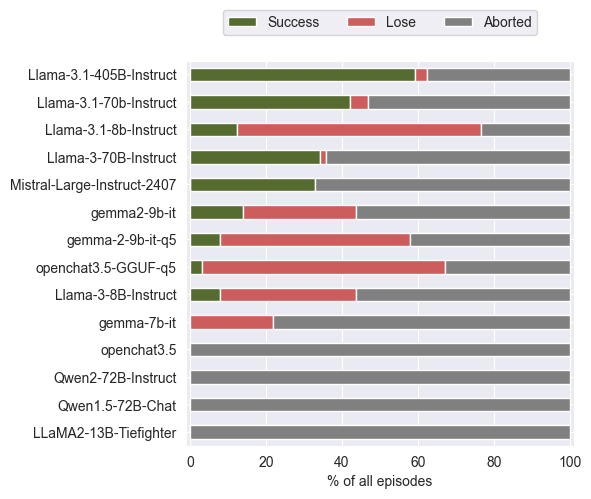

In [25]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]
df_aux = df_aux.replace(model_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

Bar plot with sorted clemscores:

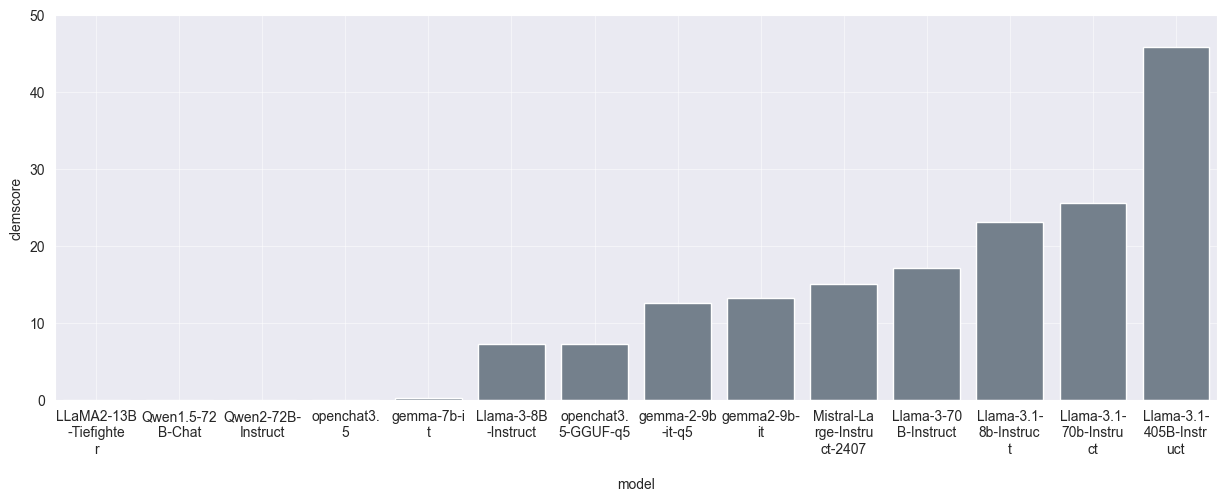

In [26]:
clem_aux = clem_df.sort_values(by='-, clemscore').reset_index(names='model').replace(model_name_dict)
# warning, if models have matching names up the limit, results will be wrongly merged!
clem_aux['model'] = clem_aux['model'].apply(lambda x: f'{x[:10]}\n{x[10:20]}\n{x[20:30]}\n{x[30:]}')

fig = plt.figure(figsize=(15, 5))
sns.barplot(clem_aux, x='model', y='-, clemscore', color='slategray')
# plt.ylim(-5, 105)
plt.ylim(0, 50)
plt.ylabel('clemscore')
plt.grid(alpha=0.5)
plt.show()

Omit models for which all episodes were aborted due to not following prompted format for detail analysis:

In [27]:
all_abort_models = ["openchat3.5", "Qwen2-72B-Instruct", "Qwen1.5-72B-Chat", "LLaMA2-13B-Tiefighter"]
game_df = game_df.query('model not in ["openchat3.5", "Qwen2-72B-Instruct", "Qwen1.5-72B-Chat", "LLaMA2-13B-Tiefighter"]')
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Parsed Request Count,50.0
2,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Request Count,50.0
3,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
36539,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_5,Played,0.0
36540,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_6,Played,1.0
36541,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_7,Played,1.0
36542,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_8,Played,0.0


## Failure metrics
### Failures by IF interpreter phase

In [28]:
failures_by_phase_df = game_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failures_by_phase_df

,game,model,experiment,episode,metric,value
5,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,action_parsing_fail,0.0
6,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,action_resolution_fail,16.0
45,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_1,action_parsing_fail,0.0
46,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_1,action_resolution_fail,18.0
85,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_10,action_parsing_fail,0.0
...,...,...,...,...,...,...
28046,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_7,action_resolution_fail,14.0
28085,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_8,action_parsing_fail,1.0
28086,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_8,action_resolution_fail,0.0
28125,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_9,action_parsing_fail,1.0


Bar plot showing failures by phase for all models over all experiments:

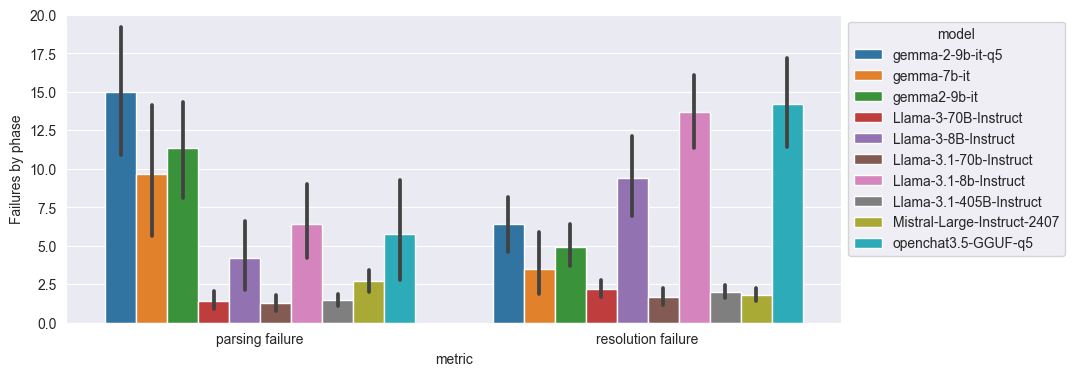

In [29]:
fig, ax = plt.subplots(figsize=(10, 4))

g = sns.barplot(failures_by_phase_df.replace(metric_name_dict),
                x='metric',
                y='value',
                hue='model',
                ax=ax)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 20)
plt.ylabel("Failures by phase")

plt.show()

Dataframe with parsed request counts, ie actions passed to the IF interpreter (used to calculate failure ratios):

In [30]:
parsed_df = game_df[game_df.metric == "Parsed Request Count"].groupby(["model"]).sum()
parsed_df = parsed_df.drop(columns=["game", 'experiment', 'episode', 'metric'])
parsed_df

,value
model,
Llama-3-70B-Instruct,1167.0
Llama-3-8B-Instruct,1635.0
Llama-3.1-405B-Instruct,1342.0
Llama-3.1-70b-Instruct,1236.0
Llama-3.1-8b-Instruct,2407.0
Mistral-Large-Instruct-2407,1087.0
gemma-2-9b-it-q5,2401.0
gemma-7b-it,963.0
gemma2-9b-it,2018.0


Counts of failures by phase for all models over all experiments:

In [31]:
failures_by_phase_counts = failures_by_phase_df.replace(metric_name_dict).groupby(['model', 'metric']).sum()
failures_by_phase_counts = failures_by_phase_counts.drop(columns=["game", 'experiment', 'episode'])
failures_by_phase_counts

value
model                       metric                   
Llama-3-70B-Instruct        parsing failure      92.0
                            resolution failure  139.0
Llama-3-8B-Instruct         parsing failure     270.0
                            resolution failure  602.0
Llama-3.1-405B-Instruct     parsing failure      93.0
                            resolution failure  129.0
Llama-3.1-70b-Instruct      parsing failure      81.0
                            resolution failure  106.0
Llama-3.1-8b-Instruct       parsing failure     412.0
                            resolution failure  874.0
Mistral-Large-Instruct-2407 parsing failure     172.0
                            resolution failure  117.0
gemma-2-9b-it-q5            parsing failure     960.0
                            resolution failure  410.0
gemma-7b-it                 parsing failure     619.0
                            resolution failure  225.0
gemma2-9b-it                parsing failure     726.0
                            resolution failure  316.0
openchat3.5-GGUF-q5         parsing failure     370.0
                            resolution failure  911.0

Ratios of failures by phase for all models over all experiments (calculated by dividing failures counts by parsed request counts):

In [32]:
failures_by_phase_ratios = failures_by_phase_counts / parsed_df
failures_by_phase_ratios

value
model                       metric                      
Llama-3-70B-Instruct        parsing failure     0.078835
                            resolution failure  0.119109
Llama-3-8B-Instruct         parsing failure     0.165138
                            resolution failure  0.368196
Llama-3.1-405B-Instruct     parsing failure     0.069300
                            resolution failure  0.096125
Llama-3.1-70b-Instruct      parsing failure     0.065534
                            resolution failure  0.085761
Llama-3.1-8b-Instruct       parsing failure     0.171167
                            resolution failure  0.363108
Mistral-Large-Instruct-2407 parsing failure     0.158234
                            resolution failure  0.107636
gemma-2-9b-it-q5            parsing failure     0.399833
                            resolution failure  0.170762
gemma-7b-it                 parsing failure     0.642783
                            resolution failure  0.233645
gemma2-9b-it                parsing failure     0.359762
                            resolution failure  0.156591
openchat3.5-GGUF-q5         parsing failure     0.163283
                            resolution failure  0.402030

Overview/model comparison stacked bar plot for successful actions and failures by phase:

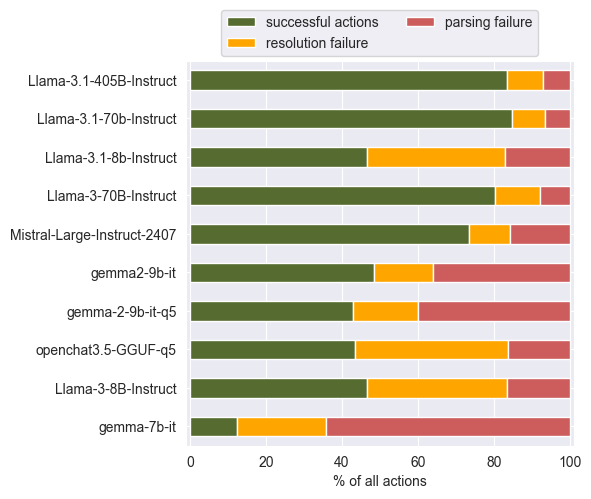

In [62]:
STACK_COLORS = ['darkolivegreen', 'orange', 'indianred']

phase_failures = ["action_parsing_fail", "action_resolution_fail", "successful_actions"]

df_aux = game_df[game_df.metric.isin(phase_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["openchat3.5", "Qwen2-72B-Instruct", "Qwen1.5-72B-Chat", "LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all actions')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Parsing failures
Dataframe with parsing failure counts/ratios:
Note: While "undefined_action" and "undefined_argument_type" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [90]:
parsing_failures_df = game_df.query('metric in ["lark_exception", "malformed_command", "undefined_action", "undefined_action_verb", "undefined_repr_str", "undefined_argument_type"]')
parsing_failures_df = parsing_failures_df.replace(metric_name_dict)
parsing_failures_counts = parsing_failures_df.groupby(['model', 'metric']).sum()
parsing_failures_counts = parsing_failures_counts.drop(columns=["game", 'experiment', 'episode'])
parsing_failures_counts['Ratio'] = parsing_failures_counts / parsed_df
parsing_failures_counts = parsing_failures_counts.rename(columns={"value": "Count"})
parsing_failures_counts

Count     Ratio
model                       metric                                
Llama-3-70B-Instruct        malformed command        0.0  0.000000
                            out of grammar           9.0  0.007712
                            undefined action type    0.0  0.000000
                            undefined action verb   69.0  0.059126
                            undefined antecedent     0.0  0.000000
                            undefined noun          14.0  0.011997
Llama-3-8B-Instruct         malformed command       48.0  0.029358
                            out of grammar          59.0  0.036086
                            undefined action type    0.0  0.000000
                            undefined action verb  102.0  0.062385
                            undefined antecedent     0.0  0.000000
                            undefined noun          59.0  0.036086
Llama-3.1-405B-Instruct     malformed command        4.0  0.002981
                            out of grammar           7.0  0.005216
                            undefined action type    0.0  0.000000
                            undefined action verb   76.0  0.056632
                            undefined antecedent     0.0  0.000000
                            undefined noun           6.0  0.004471
Llama-3.1-70b-Instruct      malformed command        5.0  0.004045
                            out of grammar           7.0  0.005663
                            undefined action type    0.0  0.000000
                            undefined action verb   65.0  0.052589
                            undefined antecedent     0.0  0.000000
                            undefined noun           4.0  0.003236
Llama-3.1-8b-Instruct       malformed command       62.0  0.025758
                            out of grammar          42.0  0.017449
                            undefined action type    0.0  0.000000
                            undefined action verb  272.0  0.113004
                            undefined antecedent     0.0  0.000000
                            undefined noun          24.0  0.009971
Mistral-Large-Instruct-2407 malformed command        2.0  0.001840
                            out of grammar          15.0  0.013799
                            undefined action type    0.0  0.000000
                            undefined action verb  142.0  0.130635
                            undefined antecedent     0.0  0.000000
                            undefined noun           3.0  0.002760
gemma-2-9b-it-q5            malformed command       10.0  0.004165
                            out of grammar         314.0  0.130779
                            undefined action type    0.0  0.000000
                            undefined action verb  623.0  0.259475
                            undefined antecedent     0.0  0.000000
                            undefined noun          12.0  0.004998
gemma-7b-it                 malformed command        9.0  0.009346
                            out of grammar         304.0  0.315680
                            undefined action type    0.0  0.000000
                            undefined action verb  290.0  0.301142
                            undefined antecedent     0.0  0.000000
                            undefined noun          15.0  0.015576
gemma2-9b-it                malformed command       10.0  0.004955
                            out of grammar         238.0  0.117939
                            undefined action type    0.0  0.000000
                            undefined action verb  474.0  0.234886
                            undefined antecedent     0.0  0.000000
                            undefined noun           4.0  0.001982
openchat3.5-GGUF-q5         malformed command       32.0  0.014122
                            out of grammar          57.0  0.025154
                            undefined action type    0.0  0.000000
                            undefined action verb  216.0  0.095322
                            und

In [91]:
parsing_failures_counts.style.format(subset="Count", precision=0).format(subset="Ratio", precision=3).to_latex('results/parsing_failures_table.tex', clines="skip-last;data")

Overview/model comparison stacked bar plot for parsing failures:
Note: Non-occurring parsing failure types are omitted here.

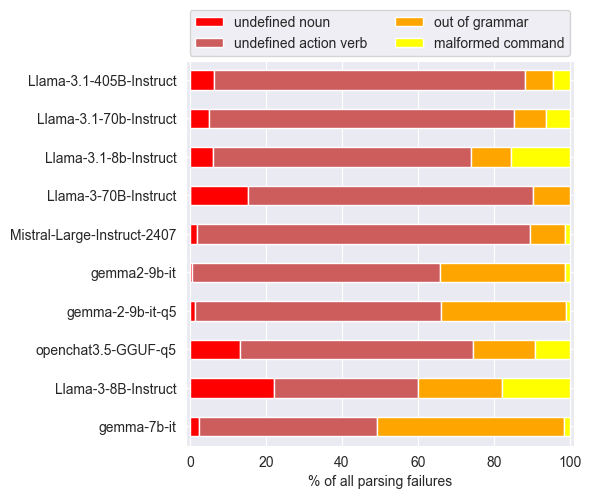

In [63]:
STACK_COLORS = ['red', 'indianred', 'orange', 'yellow']

parse_failures = ["lark_exception", "malformed_command", "undefined_action_verb", "undefined_repr_str"]

df_aux = game_df[game_df.metric.isin(parse_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["openchat3.5", "Qwen2-72B-Instruct", "Qwen1.5-72B-Chat", "LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all parsing failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Room/navigation failures
Dataframe with room/navigation failure counts/ratios:
Note: While "thing_arg1_room" and "thing_arg2_room" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [36]:
room_failures_df = game_df.query('metric in ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument", "thing_arg1_room", "thing_arg2_room"]')
room_failures_df = room_failures_df.replace(metric_name_dict)
room_failures_counts = room_failures_df.groupby(['model', 'metric']).sum()
room_failures_counts = room_failures_counts.drop(columns=["game", 'experiment', 'episode'])
room_failures_counts['ratio'] = room_failures_counts / parsed_df
room_failures_counts

value     ratio
model                       metric                                      
Llama-3-70B-Instruct        first entity is room           0.0  0.000000
                            going to non-adjacent room    64.0  0.054841
                            going to non-existent room     4.0  0.003428
                            interacting with other room    0.0  0.000000
                            manipulating room              0.0  0.000000
                            second entity is room          0.0  0.000000
Llama-3-8B-Instruct         first entity is room           0.0  0.000000
                            going to non-adjacent room    85.0  0.051988
                            going to non-existent room    30.0  0.018349
                            interacting with other room    1.0  0.000612
                            manipulating room              1.0  0.000612
                            second entity is room          0.0  0.000000
Llama-3.1-405B-Instruct     first entity is room           0.0  0.000000
                            going to non-adjacent room    73.0  0.054396
                            going to non-existent room     7.0  0.005216
                            interacting with other room    0.0  0.000000
                            manipulating room              0.0  0.000000
                            second entity is room          0.0  0.000000
Llama-3.1-70b-Instruct      first entity is room           0.0  0.000000
                            going to non-adjacent room    56.0  0.045307
                            going to non-existent room     2.0  0.001618
                            interacting with other room    0.0  0.000000
                            manipulating room              0.0  0.000000
                            second entity is room          0.0  0.000000
Llama-3.1-8b-Instruct       first entity is room           0.0  0.000000
                            going to non-adjacent room   127.0  0.052763
                            going to non-existent room   139.0  0.057748
                            interacting with other room   12.0  0.004985
                            manipulating room              0.0  0.000000
                            second entity is room          0.0  0.000000
Mistral-Large-Instruct-2407 first entity is room           0.0  0.000000
                            going to non-adjacent room    67.0  0.061638
                            going to non-existent room     2.0  0.001840
                            interacting with other room    0.0  0.000000
                            manipulating room             10.0  0.009200
                            second entity is room          0.0  0.000000
gemma-2-9b-it-q5            first entity is room           0.0  0.000000
                            going to non-adjacent room   127.0  0.052895
                            going to non-existent room    28.0  0.011662
                            interacting with other room    0.0  0.000000
                            manipulating room              1.0  0.000416
                            second entity is room          0.0  0.000000
gemma-7b-it                 first entity is room           0.0  0.000000
                            going to non-adjacent room     9.0  0.009346
                            going to non-existent room     3.0  0.003115
                            interacting with other room    1.0  0.001038
                            manipulating room              0.0  0.000000
                            second entity is room          0.0  0.000000
gemma2-9b-it                first entity is room           0.0  0.000000
                            going to non-adjacent room    95.0  0.047076
                            going to non-existent room    35.0  0.017344
                            interacting with other room    0.0  0.000000
                            manipulating room              0.0  0.000000
                            second entity 

Overview/model comparison stacked bar plot for room/navigation failures:
Note: Non-occurring room/navigation failure types are omitted here.

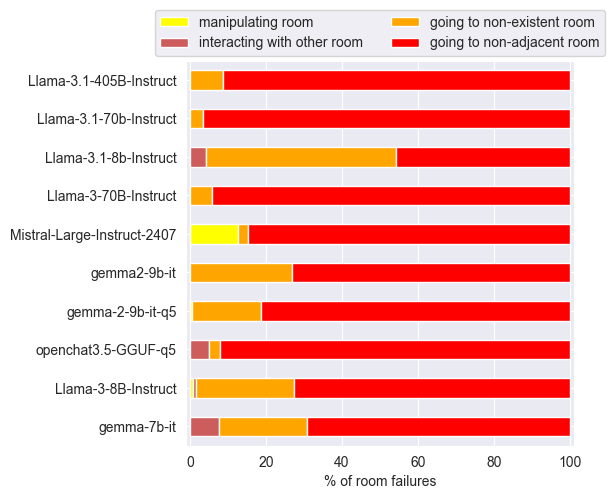

In [64]:
STACK_COLORS = ['yellow', 'orange', 'indianred', 'yellow', 'orange', 'red']

room_failures = ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument"]

df_aux = game_df[game_df.metric.isin(room_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["openchat3.5", "Qwen2-72B-Instruct", "Qwen1.5-72B-Chat", "LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of room failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

### Entity-related failures
Dataframe with entity-related failure counts/ratios:

In [38]:
entity_failures_df = game_df.query('metric in ["entity_not_accessible", "entity_already_inventory", "pre_state_mismatch"]')
entity_failures_df = entity_failures_df.replace(metric_name_dict)
entity_failures_counts = entity_failures_df.groupby(['model', 'metric']).sum()
entity_failures_counts = entity_failures_counts.drop(columns=["game", 'experiment', 'episode'])
entity_failures_counts['ratio'] = entity_failures_counts / parsed_df
entity_failures_counts

value     ratio
model                       metric                                      
Llama-3-70B-Instruct        entity already in inventory    0.0  0.000000
                            entity not accessible         69.0  0.059126
                            main condition not fact        2.0  0.001714
Llama-3-8B-Instruct         entity already in inventory    5.0  0.003058
                            entity not accessible        274.0  0.167584
                            main condition not fact      195.0  0.119266
Llama-3.1-405B-Instruct     entity already in inventory    0.0  0.000000
                            entity not accessible         48.0  0.035768
                            main condition not fact        0.0  0.000000
Llama-3.1-70b-Instruct      entity already in inventory    0.0  0.000000
                            entity not accessible         46.0  0.037217
                            main condition not fact        2.0  0.001618
Llama-3.1-8b-Instruct       entity already in inventory    6.0  0.002493
                            entity not accessible        430.0  0.178646
                            main condition not fact      171.0  0.071043
Mistral-Large-Instruct-2407 entity already in inventory    0.0  0.000000
                            entity not accessible         46.0  0.042318
                            main condition not fact        0.0  0.000000
gemma-2-9b-it-q5            entity already in inventory    1.0  0.000416
                            entity not accessible        233.0  0.097043
                            main condition not fact       15.0  0.006247
gemma-7b-it                 entity already in inventory    0.0  0.000000
                            entity not accessible        212.0  0.220145
                            main condition not fact        1.0  0.001038
gemma2-9b-it                entity already in inventory    1.0  0.000496
                            entity not accessible        154.0  0.076313
                            main condition not fact       20.0  0.009911
openchat3.5-GGUF-q5         entity already in inventory    5.0  0.002207
                            entity not accessible        553.0  0.244042
                            main condition not fact       26.0  0.011474

Overview/model comparison stacked bar plot for entity-related failures:

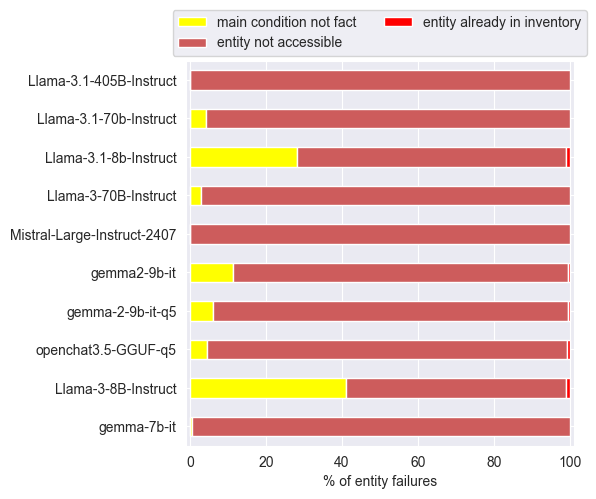

In [65]:
STACK_COLORS = ['yellow', 'indianred', 'red']

entity_failures = ["entity_not_accessible", "entity_already_inventory", "pre_state_mismatch"]

df_aux = game_df[game_df.metric.isin(entity_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.query('index not in ["openchat3.5", "Qwen2-72B-Instruct", "Qwen1.5-72B-Chat", "LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of entity failures')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

## Overview tables
Dispersion metrics over all episodes. Note that this uses groupby, which will ignore NaN values, according to the clembench documentation!

In [40]:
stats_df = build_dispersion_table(['game', 'model', 'metric'], game_df) # could also use raw_df for results for all games
stats_df

mean   
game          model                metric                               
adventuregame Llama-3-70B-Instruct Aborted                   0.640625  \
                                   Lose                      0.015625   
                                   Main Score               47.916667   
                                   Parsed Request Count     18.234375   
                                   Played                    0.359375   
...                                                               ...   
              openchat3.5-GGUF-q5  turns_over_par           10.000000   
                                   undefined_action          0.000000   
                                   undefined_action_verb     3.375000   
                                   undefined_argument_type   0.000000   
                                   undefined_repr_str        0.718750   

                                                                  std   
game          model                metric                               
adventuregame Llama-3-70B-Instruct Aborted                   0.483610  \
                                   Lose                      0.125000   
                                   Main Score               43.995751   
                                   Parsed Request Count     10.433070   
                                   Played                    0.483610   
...                                                               ...   
              openchat3.5-GGUF-q5  turns_over_par           11.313708   
                                   undefined_action          0.000000   
                                   undefined_action_verb    11.335434   
                                   undefined_argument_type   0.000000   
                                   undefined_repr_str        3.538759   

                                                                    var   
game          model                metric                                 
adventuregame Llama-3-70B-Instruct Aborted                     0.233879  \
                                   Lose                        0.015625   
                                   Main Score               1935.626102   
                                   Parsed Request Count      108.848958   
                                   Played                      0.233879   
...                                                                 ...   
              openchat3.5-GGUF-q5  turns_over_par            128.000000   
                                   undefined_action            0.000000   
                                   undefined_action_verb     128.492063   
                                   undefined_argument_type     0.000000   
                                   undefined_repr_str         12.522817   

                                                               median    max   
game          model                metric                                      
adventuregame Llama-3-70B-Instruct Aborted                   1.000000    1.0  \
                                   Lose                      0.000000    1.0   
                                   Main Score               33.333333  100.0   
                                   Parsed Request Count     16.500000   50.0   
                                   Played                    0.000000    1.0   
...                                                               ...    ...   
              openchat3.5-GGUF-q5  turns_over_par           10.000000   18.0   
                                   undefined_action          0.000000    0.0   
                                   undefined_action_verb     0.000000   48.0   
                                   undefined_argument_type   0.000000    0.0   
                                   undefined_repr_str        0.000000   25.0   

                                                            min      skew  
game          model                metric                               

In [41]:
failure_stats_by_phase_df = stats_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failure_stats_by_phase_df

mean   
game          model                       metric                              
adventuregame Llama-3-70B-Instruct        action_parsing_fail      1.437500  \
                                          action_resolution_fail   2.171875   
              Llama-3-8B-Instruct         action_parsing_fail      4.218750   
                                          action_resolution_fail   9.406250   
              Llama-3.1-405B-Instruct     action_parsing_fail      1.453125   
                                          action_resolution_fail   2.015625   
              Llama-3.1-70b-Instruct      action_parsing_fail      1.265625   
                                          action_resolution_fail   1.656250   
              Llama-3.1-8b-Instruct       action_parsing_fail      6.437500   
                                          action_resolution_fail  13.656250   
              Mistral-Large-Instruct-2407 action_parsing_fail      2.687500   
                                          action_resolution_fail   1.828125   
              gemma-2-9b-it-q5            action_parsing_fail     15.000000   
                                          action_resolution_fail   6.406250   
              gemma-7b-it                 action_parsing_fail      9.671875   
                                          action_resolution_fail   3.515625   
              gemma2-9b-it                action_parsing_fail     11.343750   
                                          action_resolution_fail   4.937500   
              openchat3.5-GGUF-q5         action_parsing_fail      5.781250   
                                          action_resolution_fail  14.234375   

                                                                        std   
game          model                       metric                              
adventuregame Llama-3-70B-Instruct        action_parsing_fail      2.280873  \
                                          action_resolution_fail   2.285598   
              Llama-3-8B-Instruct         action_parsing_fail      9.585817   
                                          action_resolution_fail  11.043520   
              Llama-3.1-405B-Instruct     action_parsing_fail      1.699016   
                                          action_resolution_fail   1.821322   
              Llama-3.1-70b-Instruct      action_parsing_fail      2.139887   
                                          action_resolution_fail   2.358495   
              Llama-3.1-8b-Instruct       action_parsing_fail      9.894483   
                                          action_resolution_fail  10.220146   
              Mistral-Large-Instruct-2407 action_parsing_fail      2.937848   
                                          action_resolution_fail   1.821866   
              gemma-2-9b-it-q5            action_parsing_fail     17.457431   
                                          action_resolution_fail   7.245620   
              gemma-7b-it                 action_parsing_fail     16.923783   
                                          action_resolution_fail   8.596773   
              gemma2-9b-it                action_parsing_fail     13.239214   
                                          action_resolution_fail   5.517289   
              openchat3.5-GGUF-q5         action_parsing_fail     14.265586   
                                          action_resolution_fail  12.526470   

                                                                         var   
game          model                       metric                               
adventuregame Llama-3-70B-Instruct        action_parsing_fail       5.202381  \
                                          action_resolution_fail    5.223958   
              Llama-3-8B-Instruct         action_parsing_fail      91.887897   
                                          action_resolution_fail  121.959325   
              Llama-3.1-405B-Instruct     action_parsing_fail       2.886657   
                                 

Break results down by experiment:

In [42]:
detailed_stats_df = build_dispersion_table(['game', 'model', 'experiment', 'metric'], game_df) # could also use raw_df for results for all games
detailed_stats_df

mean   
game          model                experiment    metric                             
adventuregame Llama-3-70B-Instruct basic-easy    Aborted                   0.4375  \
                                                 Lose                      0.0000   
                                                 Main Score               56.2500   
                                                 Parsed Request Count     17.3125   
                                                 Played                    0.5625   
...                                                                           ...   
              openchat3.5-GGUF-q5  planning-hard turns_over_par               NaN   
                                                 undefined_action          0.0000   
                                                 undefined_action_verb     0.9375   
                                                 undefined_argument_type   0.0000   
                                                 undefined_repr_str        2.6875   

                                                                                std   
game          model                experiment    metric                               
adventuregame Llama-3-70B-Instruct basic-easy    Aborted                   0.512348  \
                                                 Lose                      0.000000   
                                                 Main Score               51.234754   
                                                 Parsed Request Count      7.162111   
                                                 Played                    0.512348   
...                                                                             ...   
              openchat3.5-GGUF-q5  planning-hard turns_over_par                 NaN   
                                                 undefined_action          0.000000   
                                                 undefined_action_verb     2.462214   
                                                 undefined_argument_type   0.000000   
                                                 undefined_repr_str        6.848053   

                                                                                  var   
game          model                experiment    metric                                 
adventuregame Llama-3-70B-Instruct basic-easy    Aborted                     0.262500  \
                                                 Lose                        0.000000   
                                                 Main Score               2625.000000   
                                                 Parsed Request Count       51.295833   
                                                 Played                      0.262500   
...                                                                               ...   
              openchat3.5-GGUF-q5  planning-hard turns_over_par                   NaN   
                                                 undefined_action            0.000000   
                                                 undefined_action_verb       6.062500   
                                                 undefined_argument_type     0.000000   
                                                 undefined_repr_str         46.895833   

                                                                          median   
game          model                experiment    metric                            
adventuregame Llama-3-70B-Instruct basic-easy    Aborted                     0.0  \
                                                 Lose                        0.0   
                                                 Main Score                100.0   
                                                 Parsed Request Count       14.5   
                                                 Played                      1.0   
...                                                                          ...   
         

In [43]:
stats_df.to_csv('results/adventuregame_stats.csv')
detailed_stats_df.to_csv('results/adventuregame_stats_detailed.csv')

In [44]:
stats_df.to_html('results/adventuregame_stats.html')
detailed_stats_df.to_html('results/adventuregame_stats_detailed.html')

Planning variant:

In [45]:
plan_df = game_df.query('experiment in ["planning-easy", "planning-hard"]')
plan_df

,game,model,experiment,episode,metric,value
640,adventuregame,gemma-2-9b-it-q5,planning-easy,episode_0,Violated Request Count,1.000
641,adventuregame,gemma-2-9b-it-q5,planning-easy,episode_0,Parsed Request Count,7.000
642,adventuregame,gemma-2-9b-it-q5,planning-easy,episode_0,Request Count,8.000
643,adventuregame,gemma-2-9b-it-q5,planning-easy,episode_0,Request Success Ratio,0.875
644,adventuregame,gemma-2-9b-it-q5,planning-easy,episode_0,hallucination_count,0.000
...,...,...,...,...,...,...
36539,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_5,Played,0.000
36540,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_6,Played,1.000
36541,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_7,Played,1.000
36542,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_8,Played,0.000


Hallucinations:

In [46]:
hallucination_df = game_df[game_df.metric == 'hallucination_count']
hallucination_df

,game,model,experiment,episode,metric,value
4,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_0,hallucination_count,0.0
44,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_1,hallucination_count,0.0
84,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_10,hallucination_count,0.0
124,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_11,hallucination_count,0.0
164,adventuregame,gemma-2-9b-it-q5,basic-easy,episode_12,hallucination_count,0.0
...,...,...,...,...,...,...
27964,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_5,hallucination_count,0.0
28004,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_6,hallucination_count,0.0
28044,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_7,hallucination_count,0.0
28084,adventuregame,openchat3.5-GGUF-q5,planning-hard,episode_8,hallucination_count,0.0


In [47]:
# llama3_1_70b_hallu = hallucination_df.query('model == "llama-3.1-70b-versatile-Groq-t0.0--llama-3.1-70b-versatile-Groq-t0.0" and value == 1')
llama3_1_70b_hallu = hallucination_df.query('model == "Llama-3.1-70b-Instruct" and value == 1')
llama3_1_70b_hallu

,game,model,experiment,episode,metric,value
13004,adventuregame,Llama-3.1-70b-Instruct,basic-easy,episode_13,hallucination_count,1.0
13524,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_10,hallucination_count,1.0
13564,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_11,hallucination_count,1.0
13604,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_12,hallucination_count,1.0
13644,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_13,hallucination_count,1.0
13684,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_14,hallucination_count,1.0
13724,adventuregame,Llama-3.1-70b-Instruct,planning-easy,episode_15,hallucination_count,1.0
14124,adventuregame,Llama-3.1-70b-Instruct,basic-hard,episode_1,hallucination_count,1.0
14164,adventuregame,Llama-3.1-70b-Instruct,basic-hard,episode_10,hallucination_count,1.0
14244,adventuregame,Llama-3.1-70b-Instruct,basic-hard,episode_12,hallucination_count,1.0


In [48]:
hallucination_counts = hallucination_df.groupby(['model']).sum()
hallucination_sums = hallucination_counts.iloc[0:14, [4]]
hallucination_sums['Ratio'] = hallucination_sums.value / 64
hallucination_sums = hallucination_sums.rename(columns = {"value": "Total"})
hallucination_sums

,Total,Ratio
model,,
Llama-3-70B-Instruct,19.0,0.296875
Llama-3-8B-Instruct,4.0,0.062500
Llama-3.1-405B-Instruct,9.0,0.140625
Llama-3.1-70b-Instruct,14.0,0.218750
Llama-3.1-8b-Instruct,0.0,0.000000
Mistral-Large-Instruct-2407,4.0,0.062500
gemma-2-9b-it-q5,5.0,0.078125
gemma-7b-it,6.0,0.093750
gemma2-9b-it,5.0,0.078125


In [49]:
hallucination_sums.to_html('results/hallucination_sums.html')

In [50]:
h_styled = hallucination_sums.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="Ratio", precision=3).format(subset="Total", precision=0)
h_styled.to_latex('results/hallucination_sums.tex')

In [94]:
h_styled = hallucination_sums.style.format(subset="Ratio", precision=3).format(subset="Total", precision=0).to_latex('results/hallucination_sums.tex', clines="skip-last;data")

In [51]:
detailed_hallucination_df = build_dispersion_table(['model'], hallucination_df)
detailed_hallucination_df

,mean,std,var,median,max,min,skew
model,,,,,,,
Llama-3-70B-Instruct,0.296875,0.460493,0.212054,0.0,1.0,0.0,0.910665
Llama-3-8B-Instruct,0.062500,0.243975,0.059524,0.0,1.0,0.0,3.702124
Llama-3.1-405B-Instruct,0.140625,0.350382,0.122768,0.0,1.0,0.0,2.117502
Llama-3.1-70b-Instruct,0.218750,0.416667,0.173611,0.0,1.0,0.0,1.393548
Llama-3.1-8b-Instruct,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
Mistral-Large-Instruct-2407,0.062500,0.243975,0.059524,0.0,1.0,0.0,3.702124
gemma-2-9b-it-q5,0.078125,0.270490,0.073165,0.0,1.0,0.0,3.219966
gemma-7b-it,0.093750,0.293785,0.086310,0.0,1.0,0.0,2.854843
gemma2-9b-it,0.078125,0.270490,0.073165,0.0,1.0,0.0,3.219966


## Specific metrics plots
Bar plot overview by model and experiment:

In [52]:
def metric_bar_plot(source_df, metric, max_value=1):
    metric_df = source_df[game_df.metric == metric].sort_values('experiment')
    fig, ax = plt.subplots(figsize=(10, 4))

    g = sns.barplot(metric_df,
                x='experiment',
                y='value',
                hue='model', 
                ax=ax)

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.ylim(0, max_value)
    plt.ylabel(metric)

    plt.show()

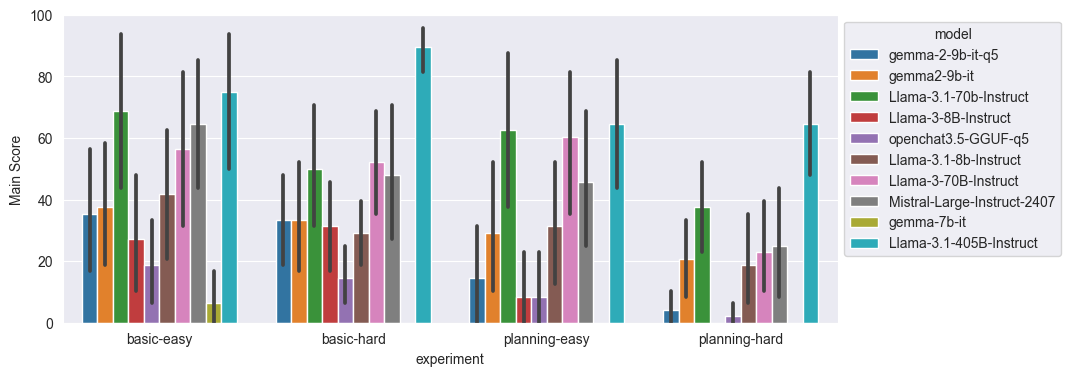

In [53]:
metric_bar_plot(game_df, "Main Score", max_value=100)

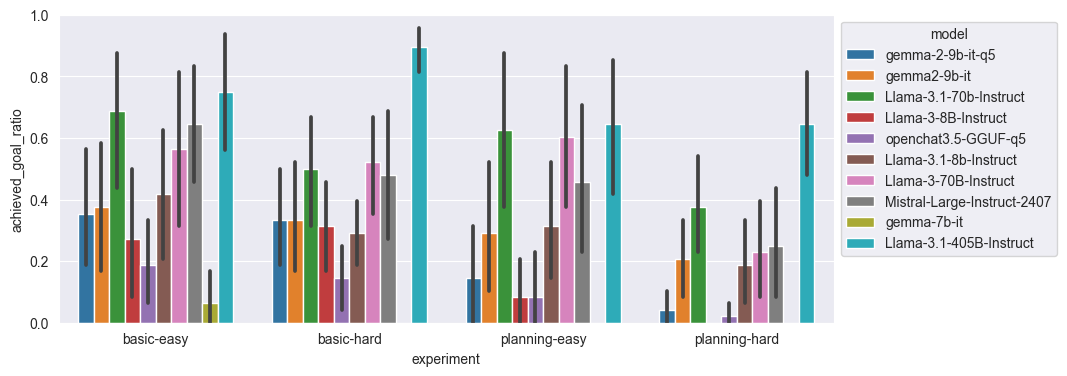

In [54]:
metric_bar_plot(game_df, "achieved_goal_ratio")

Only considering finished instances:

D:\clembench\venv_llamacpp\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
D:\clembench\venv_llamacpp\Lib\site-packages\numpy\lib\nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


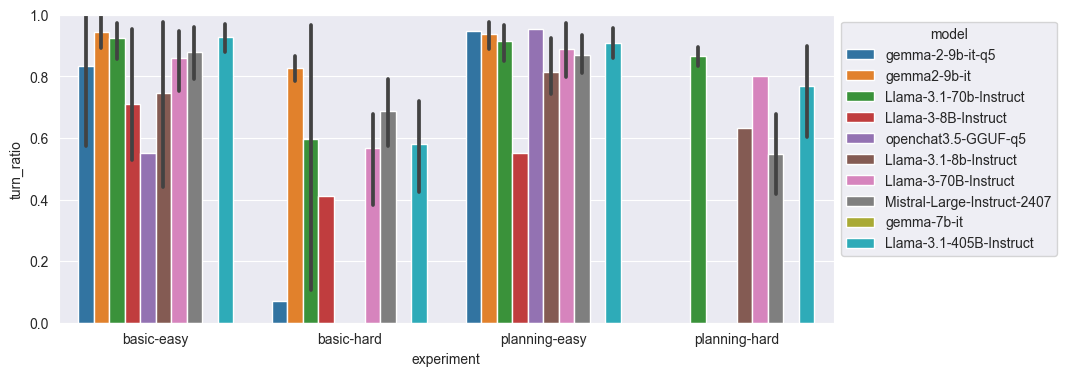

In [55]:
metric_bar_plot(game_df, "turn_ratio")

D:\clembench\venv_llamacpp\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
D:\clembench\venv_llamacpp\Lib\site-packages\numpy\lib\nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


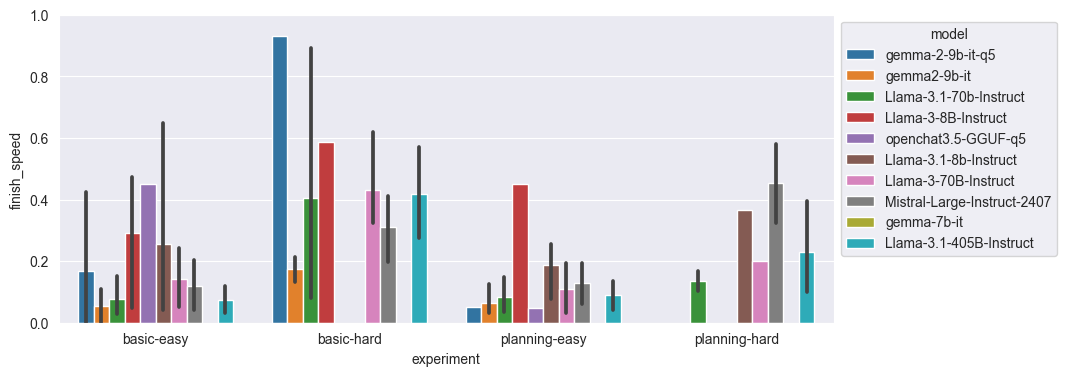

In [56]:
metric_bar_plot(game_df, "finish_speed")

Planning:

C:\Users\JJ\AppData\Local\Temp\ipykernel_13608\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


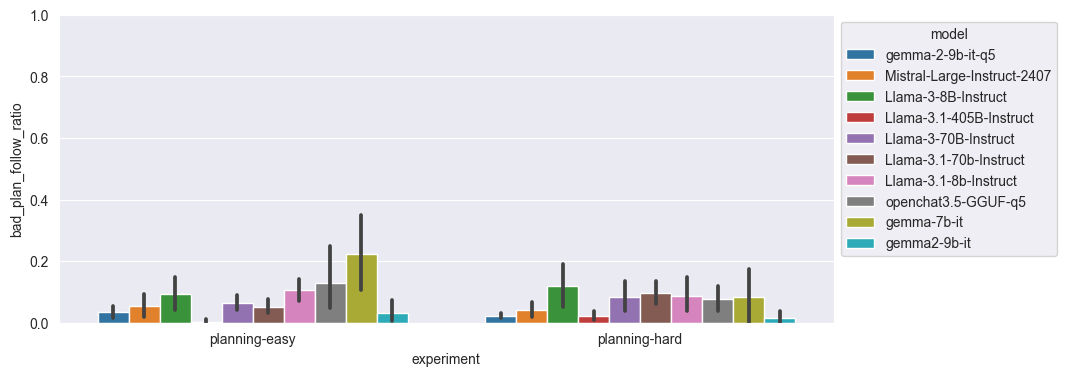

In [57]:
metric_bar_plot(plan_df, "bad_plan_follow_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_13608\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


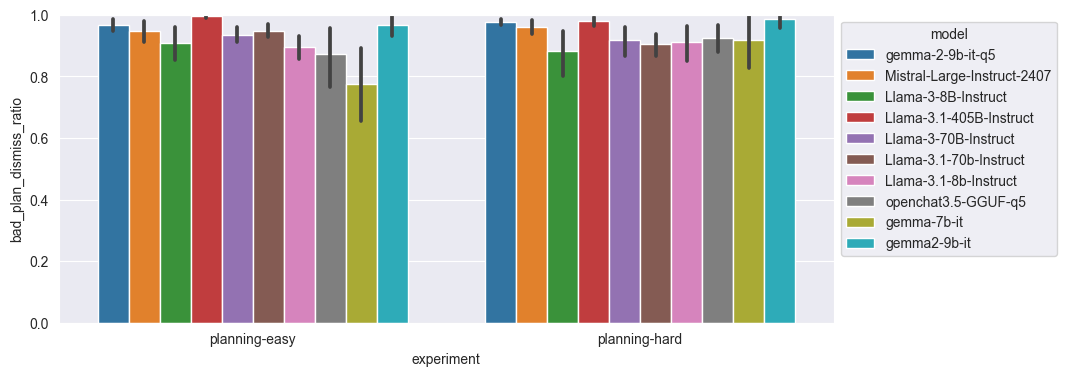

In [58]:
metric_bar_plot(plan_df, "bad_plan_dismiss_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_13608\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


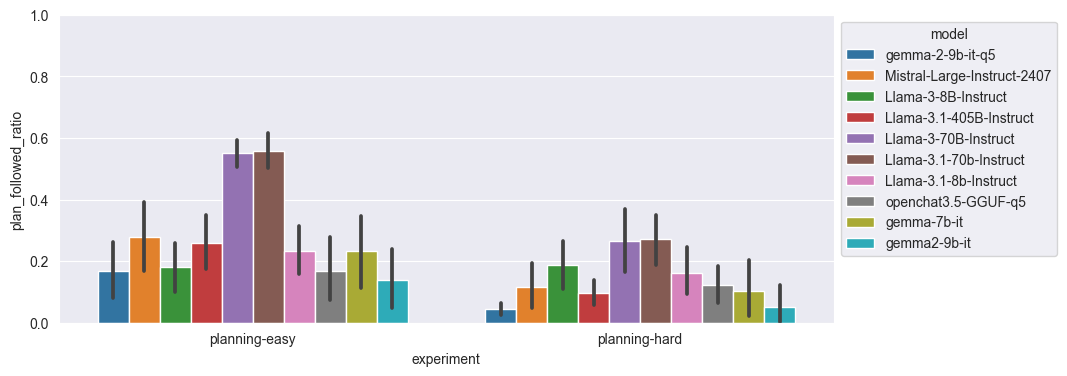

In [59]:
metric_bar_plot(plan_df, "plan_followed_ratio")

C:\Users\JJ\AppData\Local\Temp\ipykernel_13608\256060141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metric_df = source_df[game_df.metric == metric].sort_values('experiment')


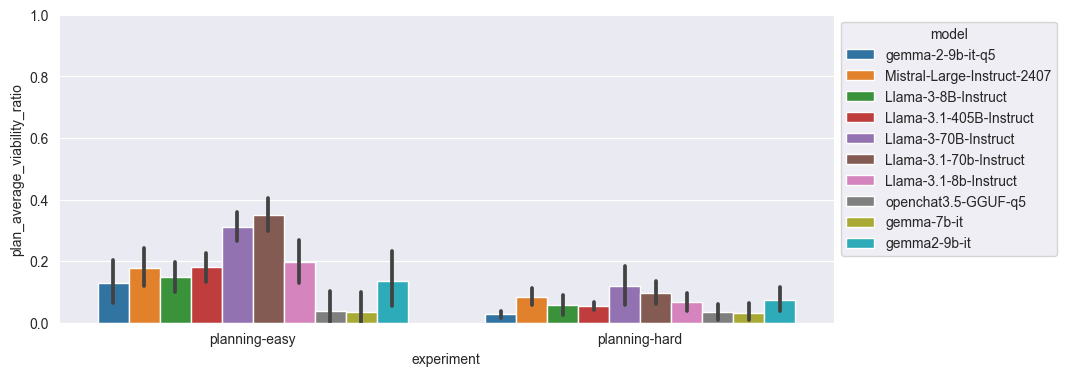

In [60]:
metric_bar_plot(plan_df, "plan_average_viability_ratio")